# Ultimate Technologies rider retention

*Lukas Vlcek*

In [1]:
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt

## Part 1: Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

**Import login data into pandas dataframe**

In [2]:
logins = pd.read_json('logins.json')
logins.info()
logins.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


**Aggregate data into 15 minutes intervals**

In [3]:
logins_15m = logins.resample('15T', on='login_time').count()
logins_15m.columns = ['login_numbers']
logins_15m.head()

,login_numbers
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


**Explore periodicity of login numbers**

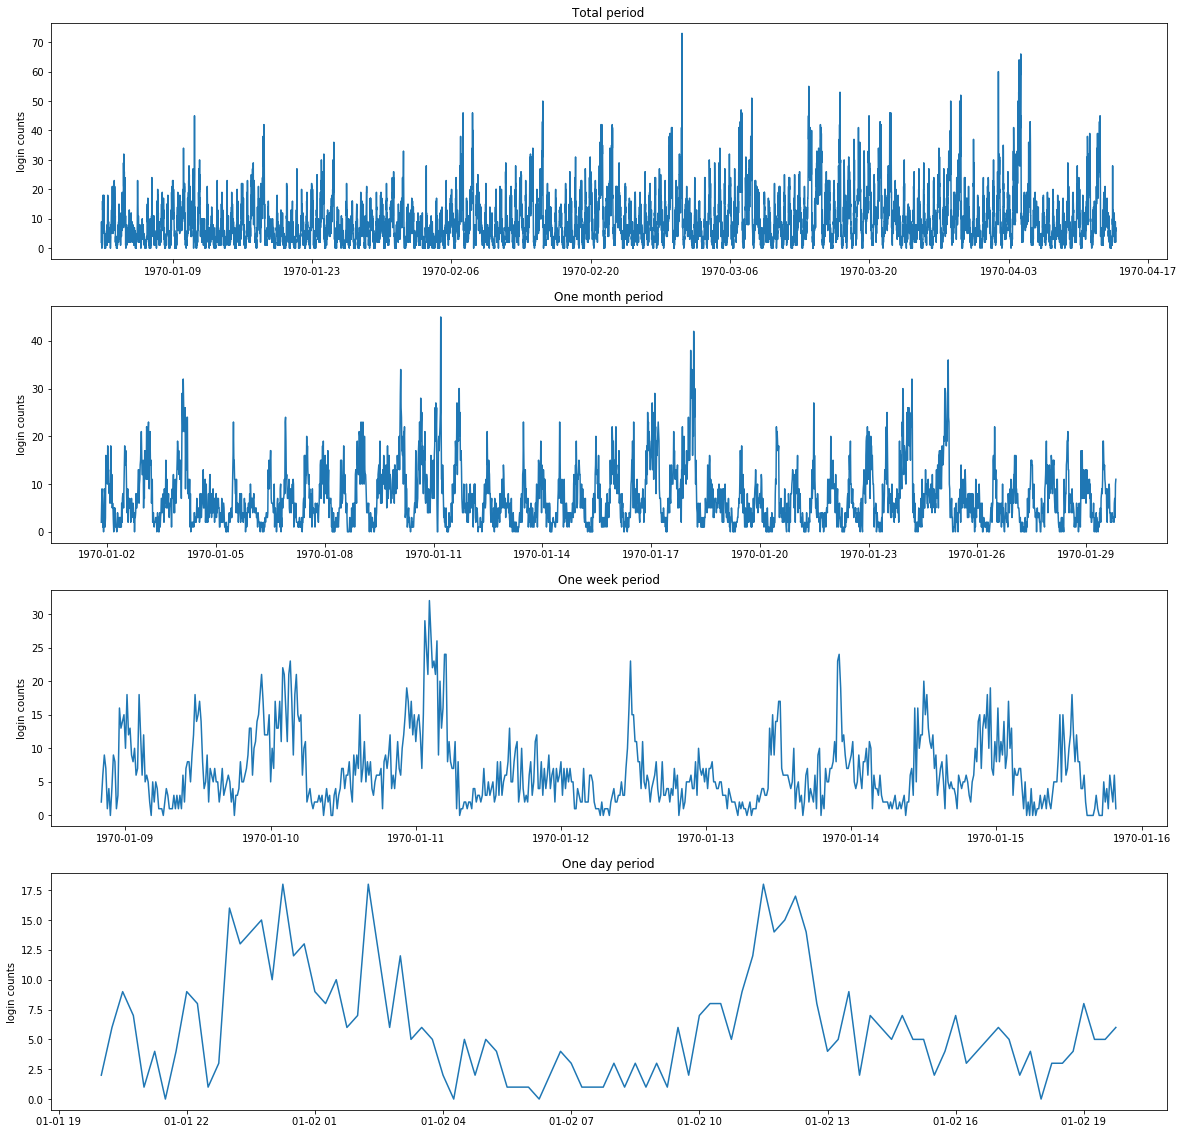

In [4]:
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(logins_15m.index[0:], logins_15m.login_numbers[0:])
plt.ylabel('login counts')
plt.title('Total period')
plt.subplot(412)
plt.plot(logins_15m.index[0:4*24*7*4], logins_15m.login_numbers[0:4*24*7*4])
plt.ylabel('login counts')
plt.title('One month period')
plt.subplot(413)
plt.plot(logins_15m.index[4*24*7 + 0:4*24*7 + 4*24*7], logins_15m.login_numbers[0:4*24*7])
plt.ylabel('login counts')
plt.title('One week period')
plt.subplot(414)
plt.plot(logins_15m.index[0+0:0+4*24], logins_15m.login_numbers[0+0:0+4*24])
plt.ylabel('login counts')
plt.title('One day period')

**Observations:** The logins show periodicity on different scales. On the daily scale (bottom plot), there are usually two spikes, one larger around midnight, and one smaller around noon. The maxima of these daily spikes follow a weekly pattern, with highest numbers of logins on wekends, especially on Sunday night. This weekly pattern repeats over the whole period covered by the data (top plot).


**Q:** Can more trends be visible on a more coarse-grained scale? Try daily aggregated data.

In [5]:
logins_1d = logins.resample('1d', on='login_time').count()
logins_1d.columns = ['login_numbers']
logins_1d.head()

,login_numbers
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


(array([ 719161.,  719175.,  719189.,  719203.,  719217.,  719231.,
         719245.,  719259.]), <a list of 8 Text xticklabel objects>)

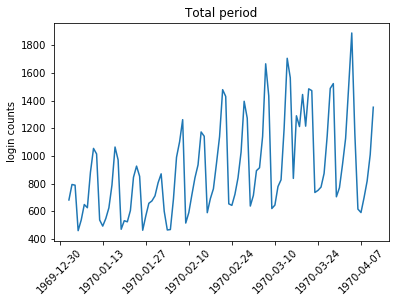

In [6]:
plt.plot(logins_1d.index[1:-2], logins_1d.login_numbers[1:-2])
plt.ylabel('login counts')
plt.title('Total period')
plt.xticks(rotation=45)

**Observation:** Plotting the same data resampled on a daily basis shows the same weely patter, but also makes it clearer that there is a gradual rise of the logins over the recorded period. There also seems to be an anomaly in the week around March 17, which exhibits unusually high activity during weekdays.

## Part 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

**A:**
The success of the experiment can be suitably measured by the absolute increase in driver partner bridge crossings for toll-reimbursed days compared to the crossings with full toll. This metric directly answers the effectivity of toll reimbursement on the desired free movement of the driver partners between the cities.

The largest increase can be expected during weekends when both cities are active at the same time. The effect can be very small (in absolute numbers) during weekdays when one of the cities is not active.

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

**A:**
The experiment could be implemented in the spirit of A/B testing. Depending on the time available for the experiment, several one week periods would be selected in which the toll is reimbursed and bridge crossings compared with weeks with full toll. Full one week periods should be preferred over daily alternations not to confuse the drivers.

With more limited time for experimentation, only one toll-reimbursed week could be tested and compared with another week that is known to be similar in traffic and city activity patterns to the week of experiment. If only one or two days are available, weekend days would be preferred because the most activity can be expected on both sides of the bridge.

b. what statistical test(s) you will conduct to verify the significance of the
observation

**A:**
For proper significance testing, multiple weekly periods should be included in the experiment to obtain information about the variance of bridge crossings. If these are collected for periods with full toll and reimbursed toll, and the distributions can be considered close to normal, 2-sample t-test can be performed, using classical frequentist testing. Alternatively significance test based on bootstraping could be used.

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

**A:**
If the significance tests indicate a real effect of the toll reimbursement on increased crossing, the resulting benefit will have to be weighted against the cost of the reimbursement. For the cost and benefit analysis, also the size of the actual effect (increase in bridge crossings) needs to be considered, since even a statistically significant but small difference may not be worth the added cost of the program. Different reimbursement plans can be devised for different days, and some refinement of the reimbursed amount could be considered to balance the costs and the benefits. If a significant effect is observed, resources for additional experiments could also be requested to test the effect of partial reimbursement, which may save the city money while still achieving the desired goal.

## Part 3: Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [7]:
# read in json data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# convert data to pandas dataframe and set proper data types
riders = pd.DataFrame(data)
riders.signup_date = pd.to_datetime(riders.signup_date, format='%Y-%m-%d')
riders.last_trip_date = pd.to_datetime(riders.last_trip_date, format='%Y-%m-%d')
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [8]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Plot last trip date statistics

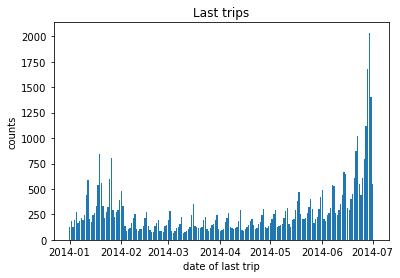

In [9]:
last_trips = riders.resample('1d', on='last_trip_date').count().last_trip_date
plt.bar(last_trips.index, last_trips)
plt.ylabel('counts')
plt.xlabel('date of last trip')
plt.title('Last trips')

The plot suggest that after initial fast drop-off in the first month (mabye just one trip) there is a steady state of last trips for most of the period. The rise in the last month includes retained customers.

Find the last recorded trip to identify (roughly) the time of survey and the period of the preceeding 30 days to evaluate user retainment.

In [10]:
print('Last reocrded trip:', riders.last_trip_date.max())

Last reocrded trip: 2014-07-01 00:00:00


Make a new boolean feature identifying a retained user.
A user will be considered 'retained' if it last used the service in June 2014.

In [11]:
import datetime
import numpy as np

In [12]:
riders['retained'] = riders.last_trip_date >= datetime.date(2014, 6, 1)

In [13]:
riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [14]:
print('Fraction of retained users:', np.mean(riders.retained))

Fraction of retained users: 0.37608


* Build a predictive model to help Ultimate determine whether or not a user will be activein their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

**A:** Predicting activity in 6 months based on historical records is a supervised binary classification task.
We considered several simple algorithms and listed them below in the order of their preference. The primary choice (logistic regression) was made based on the algorithms simplicity and speed, but we also considered common alternatives.
1. **Logistic regression (LR) - simple, fast - preferred method**
2. Support vector classifier (SVC) - more computationally expensive
3. Decision tree classifier (DT) - simple, fast, may overfit

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

Create predictor and target features.
* Target: 'retained'
* Predictors: remaining features except for signup date. Depending on how long after signup the predictions are made, we can use colomns either restricted to information available within first 30 days, or information collected over the whole period (such as averages). 

**Prepare dataframe for modeling**

In [16]:
# Make dummy variables from categorical 'phone' and 'city'
riders_data = pd.get_dummies(riders, columns=['city'], drop_first=True)
riders_data = pd.get_dummies(riders_data, columns=['phone'], dummy_na=True, drop_first=True)

# Convert boolean to integers
riders_data.ultimate_black_user = riders_data.ultimate_black_user.astype(np.int)
riders_data.retained = riders_data.retained.astype(np.int)

# Fill missing driver rating values with mean values
riders_data[['avg_rating_of_driver','avg_rating_by_driver']] = riders_data[['avg_rating_of_driver', 'avg_rating_by_driver']].apply(lambda x: x.fillna(x.mean()))

Select predictor variables

In [17]:
# Data available in the first 30 days
riders_data['city_Kings_Landing'] = riders_data["city_King's Landing"] # rename column for easy manipulation
riders_data = riders_data.drop("city_King's Landing", axis=1)
predict_start = ['city_Winterfell',"city_Kings_Landing", 'phone_iPhone', 'phone_nan', 'trips_in_first_30_days', 'ultimate_black_user', 'avg_dist']

Create predictor and target datasets

In [18]:
X_start = riders_data[predict_start].values
y = riders_data['retained'].values

Split data into training and testing sets.

In [19]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_start, y, train_size=0.8)

In [20]:
np.sum(y)/y.shape[0]

0.37608000000000003

**Logistic regression**

Simpler and faster than SVMs, with comparable predictive abilities (comparison in the Appendix), and less prone to overfitting than decision trees. The hyperparamters 'penalty' and 'C' (regularization coefficient) will be optimized using cross validation.

In [21]:
logreg = LogisticRegression()

Prepare a grid of hyperparameters for grid search

In [22]:
param_grid = {'penalty':['l1', 'l2'], 'C':list(np.logspace(-4, 1, 20))}
grid_list = sorted(param_grid)

In [23]:
gs = GridSearchCV(logreg, param_grid=param_grid, cv=5, verbose=0)

In [24]:
_ = gs.fit(Xs_train, ys_train)

Identify optimal hyper parameters

In [25]:
mean_scores = np.array(gs.cv_results_['mean_test_score']).reshape(20,2)
print('Maximum score:', mean_scores.max())
best_index = np.unravel_index(np.argmax(mean_scores, axis=None), mean_scores.shape)
print('Best hyperparameters:')
for i, j in enumerate(best_index):
    print(' ', grid_list[i],':', param_grid[grid_list[i]][j])

Maximum score: 0.71935
Best hyperparameters:
  C : 0.012742749857
  penalty : l1


**Model metrics**

Besides scalar model evaluation characterists, such as accuracy, precision, and recall, we will also evaluate a more comprehensive metrics, such as receiver operating characterictic area under curve (ROC AUC) and precision-recall area under curve (PR AUC). The latter (PR curve) is preferred for data with class imbalance. Here the fraction of retained users is ~0.38, which is reasonably balanced, so the ROC AUC will be the preferred metric. Also, our goal is to classify accurately users into categories, rather than focus on either precision or recall of the predictions.

In [26]:
ys_pred = gs.predict(Xs_test)
ys_pred_prob = gs.predict_proba(Xs_test)

In [27]:
print("Classification report\n---------------------")
print(classification_report(ys_test, ys_pred))

Classification report
---------------------
             precision    recall  f1-score   support

          0       0.72      0.85      0.78      6179
          1       0.66      0.47      0.55      3821

avg / total       0.70      0.70      0.69     10000



In [28]:
print('Accuracy on the training data:', gs.score(Xs_train, ys_train))
print('Accuracy on the testing data:', gs.score(Xs_test, ys_test))

Accuracy on the training data: 0.718975
Accuracy on the testing data: 0.705


ROC AUC (start data): 0.75242017574
Average precision score: 0.658285703051


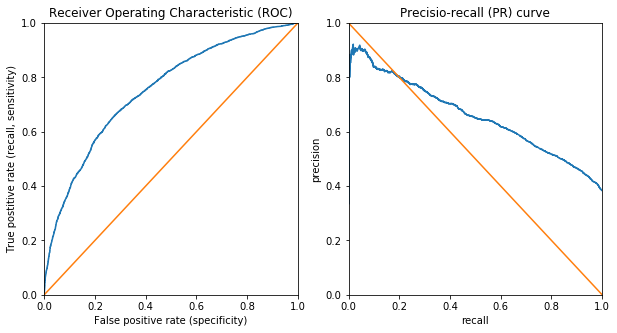

In [29]:
fprs, tprs, thresholds = roc_curve(ys_test, ys_pred_prob[:,1])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate (specificity)')
plt.ylabel('True postitive rate (recall, sensitivity)')
plt.title("Receiver Operating Characteristic (ROC)")
print('ROC AUC (start data):', roc_auc_score(ys_test, ys_pred_prob[:,1]))

ys_score = gs.decision_function(Xs_test)
precision, recall, _ = precision_recall_curve(ys_test, ys_score)
plt.subplot(122)
plt.plot(recall, precision)
plt.plot([0,1],[1,0])
plt.axis([0,1,0,1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precisio-recall (PR) curve")
print('Average precision score:', average_precision_score(ys_test, ys_score))

Based on cross-validation search, the optimal logistic regression model was achieved using L1 loss function and the regularization paramter C=0.007. With these settings, the accuracy measured on testing data was ~0.71 and the AUC for ROC curve is ~0.75, which is in the 'fair' category. While not impressively accurate, the model predictions can still provide valuable guide for decision making.

Additional modeling is presented in Appendix, including extended dataset, and the use of SVC, DecisionTree, and RandomForest methods. For some metrics (accuracy, precision, recall) SVC is slightly better than LogisticRegression, but worse for others (AUC of ROC curve).

**What features are important?**

List features and corresponding coefficient values:

In [30]:
for i in range(len(predict_start)):
    print(predict_start[i], ':', gs.best_estimator_.coef_[0][i])

city_Winterfell : 0.386572537715
city_Kings_Landing : 1.56455953702
phone_iPhone : 0.984355528793
phone_nan : 0.0
trips_in_first_30_days : 0.113723204928
ultimate_black_user : 0.800929755668
avg_dist : -0.0389445231141


**Observation:** The most important features of the dataset are the 'city', 'phone', and 'ultimate_black_user'. The least important are average distance and trips_in_fist_30_days. The absence of phone information pseud-feature was automatically eliminated (set to zero) by the L1 metric.

**Task:** Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

**A:**
1. Focus advertising on specific cities, such as King's Landing, whose inhabitants show highest retention.
2. If there is a need to choose between different software development investments, develop an iPhone app for Ultimate users.
3. Try to encourage trying Ultimate Black service after signup. It is not clear from the data whether this _causes_ higher retention, but it may be worth trying or at least conducting A/B testing.

### Appendix: extended datasets and alternative models

* **Logistic regression** grid search using all features (even those extending beyond the first 30 days)

In [31]:
# Data available over longer period of time
predict_whole = predict_start + ['avg_rating_of_driver', 'avg_rating_by_driver', 'avg_surge', 'surge_pct', 'weekday_pct']
X_whole = riders_data[predict_whole].values

# train test split for the extended dataset
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X_whole, y, train_size=0.8)

In [32]:
# cross validataion grid search 
_ = gs.fit(Xw_train, yw_train)

In [33]:
# Identify optimal parameters
mean_scores = np.array(gs.cv_results_['mean_test_score']).reshape(20,2)
print('Maximum score:', mean_scores.max())
best_index = np.unravel_index(np.argmax(mean_scores, axis=None), mean_scores.shape)
print('best', best_index)
print('Best hyperparameters:')
for i, j in enumerate(best_index):
    print(' ', grid_list[i],':', param_grid[grid_list[i]][j])

Maximum score: 0.72075
best (7, 0)
Best hyperparameters:
  C : 0.00695192796178
  penalty : l1


**Model metrics**

In [34]:
print('Accuracy on the training data:', gs.score(Xw_train, yw_train))
print('Accuracy on the testing data:', gs.score(Xw_test, yw_test))

Accuracy on the training data: 0.72035
Accuracy on the testing data: 0.7136


In [35]:
yw_pred = gs.predict(Xw_test)
yw_pred_prob = gs.predict_proba(Xw_test)
print("Classification report\n---------------------")
print(classification_report(yw_test, yw_pred))

Classification report
---------------------
             precision    recall  f1-score   support

          0       0.73      0.87      0.79      6239
          1       0.67      0.46      0.55      3761

avg / total       0.71      0.71      0.70     10000



AUC (start data): 0.75242017574
AUC (whole data): 0.760253675291


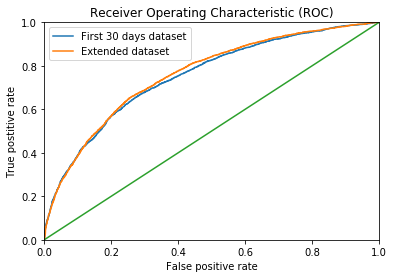

In [36]:
fprs, tprs, thresholds = roc_curve(ys_test, ys_pred_prob[:,1])
fprw, tprw, thresholds = roc_curve(yw_test, yw_pred_prob[:,1])

plt.plot(fprs, tprs, label='First 30 days dataset')
plt.plot(fprw, tprw, label='Extended dataset')
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate')
plt.ylabel('True postitive rate')
plt.legend()
plt.title("Receiver Operating Characteristic (ROC)")
print('AUC (start data):', roc_auc_score(ys_test, ys_pred_prob[:,1]))
print('AUC (whole data):', roc_auc_score(yw_test, yw_pred_prob[:,1]))

**Observation:** Based on all above metrics, the additional features do not lead to a model with better predictive abilities.

**Support vector machine model (default parameters)**

In [37]:
svc = SVC(probability=True)

In [38]:
svc.fit(Xs_train, ys_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
print('Accuracy on the training data:', svc.score(Xs_train, ys_train))
print('Accuracy on the testing data:', svc.score(Xs_test, ys_test))

Accuracy on the training data: 0.7334
Accuracy on the testing data: 0.7212


In [51]:
ys_pred = svc.predict(Xs_test)
ys_pred_prob = svc.predict_proba(Xs_test)

In [52]:
print("Classification report\n---------------------")
print(classification_report(ys_test, ys_pred))

Classification report
---------------------
             precision    recall  f1-score   support

          0       0.73      0.87      0.79      6179
          1       0.69      0.49      0.57      3821

avg / total       0.72      0.72      0.71     10000



ROC AUC (start data): 0.76127586668
Average precision score: 0.666901770235


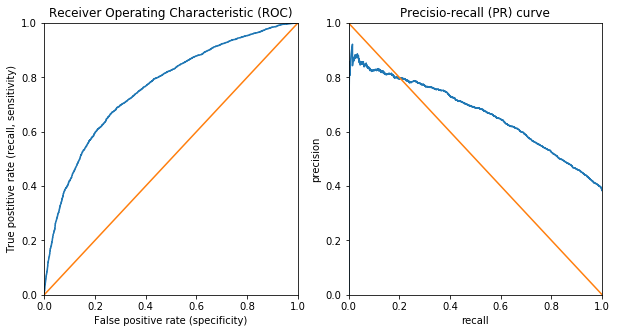

In [54]:
fprs, tprs, thresholds = roc_curve(ys_test, ys_pred_prob[:,1])
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(fprs, tprs)
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate (specificity)')
plt.ylabel('True postitive rate (recall, sensitivity)')
plt.title("Receiver Operating Characteristic (ROC)")
print('ROC AUC (start data):', roc_auc_score(ys_test, ys_pred_prob[:,1]))

ys_score = svc.decision_function(Xs_test)
precision, recall, _ = precision_recall_curve(ys_test, ys_score)
plt.subplot(122)
plt.plot(recall, precision)
plt.plot([0,1],[1,0])
plt.axis([0,1,0,1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title("Precisio-recall (PR) curve")
print('Average precision score:', average_precision_score(ys_test, ys_score))

**Observation:** The SVC model fitting is considerably longer (2 orders of magnitude) with accuracy and other metrics only slightly better than LogisticRegression. Further hyperparameter optimization may further improve SVC modele performance, and may be considered as a preferred solution.

**Decision tree and random forest classifiers**

In [44]:
tree = DecisionTreeClassifier()

In [45]:
_ = tree.fit(Xs_train, ys_train)

In [46]:
print('Accuracy on the training data:', tree.score(Xs_train, ys_train))
print('Accuracy on the testing data:', tree.score(Xs_test, ys_test))

Accuracy on the training data: 0.91165
Accuracy on the testing data: 0.6555


In [47]:
forest = RandomForestClassifier()

In [48]:
_ = forest.fit(Xs_train, ys_train)

In [49]:
print('Accuracy on the training data:', forest.score(Xs_train, ys_train))
print('Accuracy on the testing data:', forest.score(Xs_test, ys_test))

Accuracy on the training data: 0.892225
Accuracy on the testing data: 0.6616


**Observation:** Both methods, which are known to be vulnerable to overfitting, tend to overfit the training data when default parameters are used. 